# Trotterization

In order to approximate the unitary time evolution by a [circuit](https://qiskit.org/documentation/apidoc/circuit.html) on a quantum computer, we have to decompose $U(t)=e^{-iH t/\hbar}$ into a product of single and two-qubit gates that are native to the device. In this exercise, we use [Trotterization](https://en.wikipedia.org/wiki/Hamiltonian_simulation#Product_Formulas). 

Below, we show an example Trotterization as outlined in \[1-2\].

Consider the two-body terms of the Hamiltonian, $H^{(i,j)} = \sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}$.

The unitary operator of the time evolution operator is given by:

$$
U(t) = \exp\left[-i t \left(H^{(0,1)} + H^{(1,2)} + H^{(2,3)}\right)\right].
$$
A naive guess to express the unitary operator by a circuit is to simply split it up into its two-gate parts, but this does not work since the [Pauli operators do not commute](https://en.wikipedia.org/wiki/Pauli_matrices#Commutation_relations) with each other: the exponential $U(t)$ **cannot** be split into a product of simpler exponentials: 

$$
U(t) \neq \exp\left(-i t (H^{(0,1)}\right) \exp\left(-i t (H^{(2,3)}\right)\exp\left(-i t H^{(1,2)} \right)
$$

However we can do better. Lets imagine we decompose our time evolution in $n$ smaller steps of size $t/n$. When we try do factorize each step by its own again, we still get a small error, but its size is linear in the time step $t/n$. It can be shown that the error vanishes in the limit $n → \infty $:

$$
\begin{align}
U(t) &= \exp\left[-i t \left(H^{(0,1)} + H^{(1,2)}+H^{(2,3)} \right)\right]
= \left[\exp\left(-i \frac{t}{n} \left(H^{(0,1)} + H^{(1,2)}+ H^{(2,3)} \right)\right) \right]^n \\
&\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}\right) \exp\left(\dfrac{-it}{n}H^{(2,3)}\right)\exp\left(\dfrac{-it}{n}H^{(1,2)} \right)\right]^n.
\end{align}
$$

$n$ is the number of Trotter steps; Note that the way the unitary time-evolution operator is split up into subsystems for Trotterization is not necessarily unique.

We can further decompose each step ,since pairs of Pauli operators commute:

$$
\begin{align}
\exp\left(\dfrac{-it}{n}H^{(j,j+1)}\right) =
\exp\left(\dfrac{-it}{n}\left(\sigma_x^{(j)}\sigma_x^{(j+1)}\right)\right) 
\exp\left(\dfrac{-it}{n}\left(\sigma_y^{(j)}\sigma_y^{(j+1)}\right)\right) 
\end{align}.
$$

For simplicity we use in the following the convential notation
$$
\begin{align}
XX(2t) &= \exp\left(-it \sigma_x\sigma_x\right)\\
YY(2t) &= \exp\left(-it \sigma_y\sigma_y\right) 
\end{align}
$$

We have now reduced the task of simulating the spin chain to a much simpler problem, namely finding a implementation of the gates $XX(t)$ and $YY(t)$.
This is your task in the following exercises.

*Further references for digital quantum simulations*

\[1\] Y. Salathe, et al., *Digital Quantum Simulation of Spin Models with Circuit Quantum Electrodynamics*, [Phys. Rev. X **5**, 021027 (2015)](https://link.aps.org/doi/10.1103/PhysRevX.5.021027)

\[2\] F. Tacchino, et al., *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Adv. Quantum Technol. *3* 3 (2020)](https://doi.org/10.1002/qute.201900052) \[[free arxiv version](https://arxiv.org/abs/1907.03505)\]

\[3\] K. Ferris, et al., *Quantum Simulation on Noisy Superconducting Quantum Computers*, [arXiv:2209.02795v1 (2022)](https://arxiv.org/pdf/2209.02795.pdf)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, transpile, Aer, IBMQ, execute,ClassicalRegister
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from tqdm.notebook import tqdm
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer import AerSimulator #A library to simulate quantum computers with noise on a classical device
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter,Gate,Measure

import qiskit.quantum_info as qi

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Time evolution under a static Hamiltonian

First, let's consider time evolution under the tight-binding Hamiltonian on 4 lattice sites. Here we'll set $J=1$ and perform the time evolution on the classical computer using the [qiskit operator module]((https://qiskit.org/documentation/tutorials/operators/01_operator_flow.html)). At the end of this notebook, you will have the opportunity to run your code on the quantum computer.  

In [3]:
# Import Pauli operators (I, X, Y, Z)
from qiskit.opflow import I, X, Y, Z 

J = 1 # set energy unit

# tight-binding Hamiltonian
def H_tb(n):
    # Interactions: I is the identity matrix; X and Y are Pauli matricies; n is the number of qubits
    # ^ stands for the tensor product
    XXs = (X^X^(I^(n-2)))
    YYs=  (Y^Y^(I^(n-2)))
    for k in range(1,n-1):
      XXs+=(((I^k)^(X^X)^(I^(n-2-k))))
      YYs+=(((I^k)^(Y^Y)^(I^(n-2-k))))
    # Sum interaction terms
    H = J*(XXs + YYs)    
    
    # Return Hamiltonian
    return H

In [4]:
# Unitary evolution under the tight-binding Hamiltonian
def U_tb(t,n):
    # n is the number of qubits; t is the time (different from time step)
    H = H_tb(n)
    return (t * H).exp_i() # Compute exp(-iHt), efficient for 4 qubits

We initialize the state of our system to $|1000\rangle$, and track the probabilities of the states $|1000\rangle, |0100\rangle, |0010\rangle, |0001\rangle$. These values correspond to the probability of finding a spin up on any site of the lattice.

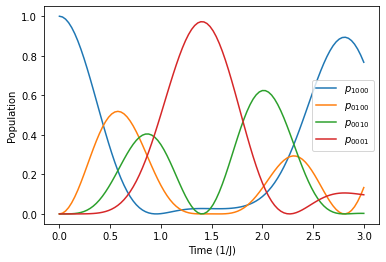

In [5]:
# Import qubit states Zero (|0>) and One (|1>)
from qiskit.opflow import Zero, One

# Define array of time points
ts = np.linspace(0, 3, 100) # DO NOT CHANGE THIS

initial_state=One^Zero^Zero^Zero
L=4 #Number of qubits

state_t=[U_tb(float(t),L) @ initial_state for t in ts] #Object that contains the whole state for each time step

# In the following lines we ask for the probability to get the given state, e.g. |1000>, at each time.  One^Zero^Zero^Zero corresponds to the state |1000> etc.
# eval() executes the operations instructed by the operations build in the previous line then the absolute value is taken
p_1000= [np.abs( (~(One^Zero^Zero^Zero) @ state).eval() )**2 for state in state_t] #compute the overlap between the state |1000> and the time evolved state under th Hamiltonian
p_0100= [np.abs( (~(Zero^One^Zero^Zero) @ state).eval() )**2 for state in state_t]
p_0010= [np.abs( (~(Zero^Zero^One^Zero) @ state).eval() )**2 for state in state_t]
p_0001= [np.abs( (~(Zero^Zero^Zero^One) @ state).eval() )**2 for state in state_t]

plt.figure(facecolor='white')
plt.plot(ts, p_1000, label=r'$p_{1000}$')
plt.plot(ts, p_0100, label=r'$p_{0100}$')
plt.plot(ts, p_0010, label=r'$p_{0010}$')
plt.plot(ts, p_0001, label=r'$p_{0001}$')
plt.xlabel(r'Time (1/J)')
plt.ylabel(r'Population')
plt.legend()
plt.show()

$\color{red}{\text{Question: How many basis states are there in the Hilbert space? Why has the time-evolved initial state only overlap with the four basis states plotted above?}}$

## 2. Trotterization in a nutshell

To execute the unitary time evolution on a [circuit model](https://qiskit.org/documentation/apidoc/circuit.html) quantum computer, we must decompose $U(t)=e^{-iH t/\hbar}$ into a product of single and two-qubit gates that are native to the quantum computer. In this exercise, we use [Trotterization](https://en.wikipedia.org/wiki/Hamiltonian_simulation#Product_Formulas). 

Below, we show an example Trotterization as outlined in \[1-2\].

Since the [Pauli operators do not commute](https://en.wikipedia.org/wiki/Pauli_matrices#Commutation_relations) with each other, the exponential $U_{\text{tb}}(t)$ cannot be split into a product of simpler exponentials. However, we can approximate $U(t)$ as a product of simpler exponentials through Trotterization. 

Consider a subsystem of 2 spin-1/2 particles within the larger 3 spin system. The Hamiltonian on spins $i$ and $j\,$ ($i,j \in \{0,1,2\}$) would be $H^{(i,j)} = \sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}$. Rewritting $U(t)$ in terms of the two possible subsystems within the total $N=3$ system we want to simulate

$$
U(t) = \exp\left[-i t \left(H^{(0,1)} + H^{(1,2)} \right)\right].
$$

Note that $H^{(0,1)}$ and $H^{(1,2)}$ do not commute, so $U(t) \neq \exp\left(-i t H^{(0,1)}\right) \exp\left(-i t H^{(1,2)} \right)$. But, this product decomposition can be approximated with Trotterization which states that $U(t)$ is approximately a short evolution of $H^{(0,1)}$ (time = $t/n$)  and followed by a short evolution of $H^{(1,2)}$ (time = $t/n$) repeated $n$ times

$$
\begin{align}
U(t) &= \exp\left[-i t \left(H^{(0,1)} + H^{(1,2)} \right)\right]
= \left[\exp\left(-i \frac{t}{n} \left(H^{(0,1)} + H^{(1,2)} \right)\right) \right]^n \\
U(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)} \right)\right]^n.
\end{align}
$$

Here $n$ is the number of Trotter steps; as $n$ increases, the approximation becomes more accurate. (Note tha the way the unitary time-evolution operator is split up into subsystems for Trotterization is not necessarily unique.) The decomposition goes further. Within each 2 spin subsystems, the Pauli operator pairs ($\sigma_x^{(i)}\sigma_x^{(j)}$, $\sigma_y^{(i)}\sigma_y^{(j)}$, and $\sigma_z^{(i)}\sigma_z^{(j)}$) commute. 

This means we can decompose the exponential of a subsystem Hamiltonian $H^{(i,j)}$ into a product of even simpler exponentials getting us closer to a gate implementation of $U(t)$:

$$
\begin{align}
U(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)} \right)\right]^n \\
&= \left[\exp\left(\dfrac{-it}{n}\left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} \right)\right) \exp\left(\dfrac{-it}{n}\left(\sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} \right)\right)\right]^{n} \\
&= \left[\exp\left(\dfrac{-it}{n}\sigma_x^{(0)}\sigma_x^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(0)}\sigma_y^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_x^{(1)}\sigma_x^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(1)}\sigma_y^{(2)}\right) \right]^{n}
\end{align}
$$

For simplicity, and to use a more common notation, let's rename the products with $XX(2t) = \exp\left(-it \sigma_x\sigma_x\right)$, and $YY(2t) = \exp\left(-it \sigma_y\sigma_y\right)$, and rewrite the Trotterized $U_{\text{tb}}(t)$ as
$$
U(t) \approx \left[XX\left(\frac{2t}{n}\right)^{(0,1)} YY\left(\frac{2t}{n}\right)^{(0,1)}  XX\left(\frac{2t}{n}\right)^{(1,2)} YY\left(\frac{2t}{n}\right)^{(1,2)}\right]^{n}.
$$
And that's it! We have now approximately decomposed $U(t)$ into two-qubit gates $XX(t)$ and $YY(t)$. These gates are not native to superconducting qubits, but in Section 2, they will be further decomposed into native single and two-qubit gates with *further details found in the supplementary material.*


\[1\] Y. Salathe, et al., *Digital Quantum Simulation of Spin Models with Circuit Quantum Electrodynamics*, [Phys. Rev. X **5**, 021027 (2015)](https://link.aps.org/doi/10.1103/PhysRevX.5.021027)

\[2\] F. Tacchino, et al., *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Adv. Quantum Technol. *3* 3 (2020)](https://doi.org/10.1002/qute.201900052) \[[free arxiv version](https://arxiv.org/abs/1907.03505)\]


### 2.1 Building the $XX(t)$ and $YY(t)$ gates

In this section we build ZZ(t), XX(t), and YY(t) operations using single- and two-qubit gates. We need a set of basis gates (see notebook frequently_used_operations.ipynb for overview of the main gates used). 

You will first see a way of implementing the ZZ(t) gate; then you will have to do the same for the YY(t) and XX(t) gates.

In [10]:
t = Parameter('t') #time parameter

In the following example, it is shown how to construct a $ZZ(t)$-gate

In [11]:
# Build a subcircuit for ZZ(t) from single- and two-qubit gates

ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')
ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cnot(0,1)
# Convert custom quantum circuit into a gate
ZZ = ZZ_qc.to_instruction()
ZZ_qc.draw()

q4_0: ──■───────────────■──
      ┌─┴─┐┌─────────┐┌─┴─┐
q4_1: ┤ X ├┤ Rz(2*t) ├┤ X ├
      └───┘└─────────┘└───┘

### 2.2 Basis transformations

Once we know how to construct the $ZZ(t)$ gate, it is straightforward to implement $XX(t)$ and YY(t) . In particular, there is a class of quantum operators that map Pauli operators to other Pauli operators: the Clifford gates. The Hadamard gate ($H$) (see exercise 1a) and the phase gate ($S$) are examples of single-qubit Clifford gates.

$$H=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\1 & -1\\ \end{pmatrix}$$

$HZH^\dagger=X$, and $HXH^\dagger=Z$. Since the Hadamard gate is a Hermitian operator, $H=H^\dagger$.

$$S=\begin{pmatrix} 1 & 0 \\0 & i\\ \end{pmatrix}$$

$SXS^\dagger=Y$, and $SYS^\dagger=-X$.

Using the Clifford gates, we can transform the $e^{i ZZ t}$ to $e^{i XX t}$ and $e^{i YY t}$

$\color{red}{\text{Exercise 1a: Construct a XX gate using the basis transformation shown above.}}$

Hint: use the Hadamard gate to perform a transformation from the $ZZ(t)$ to the $XX(t)$ gate, the circuit diagram is shown below:

![balanced1.png](XXtgate.png)

In [17]:

XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')

#Your code goes here


## Append the ZZ gate 
XX_qc.append(ZZ, [0,1])

#Your code goes here


# Convert custom quantum circuit into a gate
XX = XX_qc.to_instruction()

XX_qc.draw()

┌────────┐
q10_0: ┤0       ├
       │  ZZ(t) │
q10_1: ┤1       ├
       └────────┘


$\color{red}{\text{Exercise 1b: Construct a YY gate from single and two-body qubit gates}}$

Hint: use again a basis transformation, as in the circuit diagram for the $YY(t)$ gate shown below:

![balanced1.png](YYtgate.png)

In [18]:
YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')

#Your code goes here

## Append the ZZ gate 
YY_qc.append(ZZ, [0,1])

#Your code goes here



# Convert custom quantum circuit into a gate
YY = YY_qc.to_instruction()

YY_qc.draw()

┌────────┐
q11_0: ┤0       ├
       │  ZZ(t) │
q11_1: ┤1       ├
       └────────┘

### 2.3 Building the trotterized circuit

You may have noticed already that the $X_iX_j$ and $Y_iY_j$ operators commute:

$$[X_iX_j, Y_iY_j]= X_iX_j.Y_iY_j - Y_iY_j.X_iX_j = Z_iZ_j-(-Z_i)(-Z_j)=0.$$

Therefore, we can decompose $e^{i t (X_iX_j + Y_iY_j)}$ as $e^{i t X_iX_j} e^{i t Y_iY_j}$ without incurring additional errors.

Furthermore, if $i\neq j \neq k \neq l$ then $[X_iX_j,X_kX_l]=0$. Based on this, we can decompose each trotterized evolution time step into two blocks:

$$U(\Delta t) \approx \Big(\prod_{i \in \rm{odd}} e^{-i \Delta t X_iX_{i+1}} e^{-i \Delta t Y_iY_{i+1}} \Big)  \Big(\prod_{i \in \rm{even}} e^{-i \Delta t X_iX_{i+1}} e^{-i \Delta t Y_iY_{i+1}} \Big)$$

We are now able to construct one Trotter step:

In [19]:
num_qubits = 4

Trot_qr = QuantumRegister(num_qubits) #Full circuit
Trot_qc = QuantumCircuit(Trot_qr, name='Trot') #Trotter on a single bond

for i in range(0, num_qubits - 1,2):#even qubits
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])
for i in range(1, num_qubits - 1,2):#odd qubits
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

# Convert custom quantum circuit into a multi-qubit gate
Trot_gate = Trot_qc.to_instruction()

Trot_qc.draw()

┌────────┐┌────────┐                    
q12_0: ┤0       ├┤0       ├────────────────────
       │  YY(t) ││  XX(t) │┌────────┐┌────────┐
q12_1: ┤1       ├┤1       ├┤0       ├┤0       ├
       ├────────┤├────────┤│  YY(t) ││  XX(t) │
q12_2: ┤0       ├┤0       ├┤1       ├┤1       ├
       │  YY(t) ││  XX(t) │└────────┘└────────┘
q12_3: ┤1       ├┤1       ├────────────────────
       └────────┘└────────┘

$\color{red}{\text{Exercise 2: Construct the Trotter circuit for the underlying time evolution with a given number of trotter_steps}}$

We created a single Trotter step before. Given a time $t_{\text{target}}$ and a number of Trotter steps  $q$ Trotter steps, your code has to apply $q$ Trotter steps of time $t/q$.

In [27]:

def U_trotterize(t_target, trotter_steps,n_qubits):
    qr = QuantumRegister(n_qubits) #create a quantum register
    qc = QuantumCircuit(qr)        #create quantum circuit
    #Your code goes here
    
    for k in range(trotter_steps):
        for i in range(0, n_qubits - 1,2):#even qubits
            qc.append(YY, [qr[i], qr[i+1]])
            qc.append(XX, [qr[i], qr[i+1]])
        for i in range(1, n_qubits - 1,2):#odd qubits
            qc.append(YY, [qr[i], qr[i+1]])
            qc.append(XX, [qr[i], qr[i+1]])

    qc = qc.bind_parameters({t: t_target/trotter_steps})  #fix the free time parameter in your circuit to be $t_target/trotter_steps$  
    return qi.Operator(qc)


Let us now check the accuracy of our Trotter circuit.

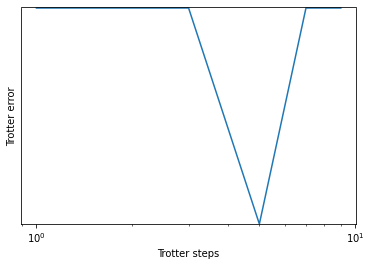

In [28]:
t_target = 0.5 #total evolution time of the circuit
nqubits=4
U_target = U_tb(t_target,nqubits) #Compute the unitary for the exact time evolution
steps=np.arange(1,11,2)  #various number of Trotter steps
fidelities=[]
for n in steps:
    U_trotter = U_trotterize(t_target, trotter_steps=n,n_qubits=nqubits) #construct the Trotter_circuit
    fidelity = qi.process_fidelity(U_trotter, target=U_target) #compute the overlap with the exact time evolution
    fidelities.append(fidelity)

plt.figure(facecolor='white')
plt.loglog(steps, 1-np.array(fidelities))
plt.ylabel('Trotter error')
plt.xlabel('Trotter steps')
plt.show()

## 3. Execution on a real quantum device

The accuracy of our Trotter time evolution improves with the number of steps. However, the accuracy of simulation on a quantum device gets spoiled with increasing number of steps due to gate erroors and decay of excited qubits. In the following section, you have the chance to explore this behavior on a real device.

In [29]:
IBMQ.save_account("740cf9a029345b5770ad72af52ca4d1c51eb8afe78c6d95e17ecffd2e72033a693cf8563418f2143cf5d9780f497e3100577f0a400d882f5d4314ca68ce9fc37",overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research-2',group='max-planck-inst',project='codingchallenge')
n=5
backend=provider.get_backend('ibm_oslo')
backendsim=AerSimulator()
backend2= AerSimulator.from_backend(backend) #In case we have to long waiting times on a real device, we use a noisy simulator instead


ibmqfactory.load_account:WARNING:2022-09-30 14:56:41,510: Credentials are already in use. The existing account in the session will be replaced.


In the following part, we define for each time step a circuit, which we execute then on the real device. 

In [30]:
circuits=[]
n_qubits=5 #Number of qubits, use not more than 7, maximum 5 are recommended
dt=0.1     #Size of one itme step
steps=50   #Number of Trotter steps
shots=1024 #Number of repeated measurements
#We prepare for each timestep a circuit
for i in range(1,steps):
        qr = QuantumRegister(n_qubits)
        cl = ClassicalRegister(n_qubits)
        qc = QuantumCircuit(qr,cl)
        #perpare domain wall states, the left half in an excited states, the right half in a down state
        for j in range(n_qubits//2):
            qc.x(j)
        #add the Trotter circuit
        qc.append(U_trotterize(t_target=dt*i,trotter_steps=i,n_qubits=n_qubits),list(range(n_qubits)))
        for j in range(n_qubits):#Measure
            qc.append(Measure(),[qr[j]],[cl[j]])
        circuits.append(qc)

Run the next section to evaluate the circuits on real device. If it takes too long, you can switch to a noisy simulator.
For the sake of a comparison, we also run the same circuits on a noise-free device.

In [ ]:
circuitssim = transpile(circuits, backend,optimization_level=1) #transpile the circuits
job = backend.run(circuitssim,shots=shots) #If the evaluation on a real device takes too long, switch from backend to backend2
job_monitor(job, interval=2)
job2 = backendsim.run(circuitssim,shots=shots) #execute the circuits on a noiseless simulator
job_monitor(job2, interval=2)

Job Status: job is queued (343)   

We can also measure the behavior of obsevables. Below we look at the magnetization pattern and compare it using an exact time simulation. To do so, we have to write a function which converts the measurement counts of each state to a magnetization pattern.

In [ ]:
def counts_to_magnetization_pattern(n,results,shots=1024):
    result=np.zeros((len(results.results),n))
    for i in range(len(results.results)): #compute magnetization pattern for each timestep
      lists=results.results[i].data.counts #list with the measured results and how often each of them was detected
      for k in lists.keys():
        res=int(k,16) #convert binary string of the output to an integer number
        in1=(res//(2**np.arange(n)))%2 #convert the measurment output to a magnetization pattern, i.e the measurment output 16 corresponds to the string pattern "01111" 
        result[i,:]+=lists[k]*in1/shots #weight each output with the number of detections and add it to the total result
    return result

In the following lines we extract the magnetization from our results.

In [ ]:
result=job.result()
real_result=np.zeros((steps,n_qubits))
for i in range(n_qubits//2): #the first entry encodes the initial magnetization pattern at time step t=0
  real_result[0,i]=1
real_result[1:,:]=counts_to_magnetization_pattern(n_qubits,result,shots=shots) #evaluate the magnetization for the result on the quantum device

#Do the same for the noiseless simulations
resultsim=job2.result()
sim_result=np.zeros((steps,n_qubits)) 
for i in range(n_qubits//2):  #the first entry encodes the initial magnetization pattern at time step t=0
  sim_result[0,i]=1
sim_result[1:,:]=counts_to_magnetization_pattern(n_qubits,resultsim,shots=shots) #evaluate the magnetization for the result on the quantum device

Finally we can compare the results on a quantum computer with a noiseless simulator. What do you see?

In [1]:
time=np.linspace(0,dt*(steps),steps)
n=np.arange(n_qubits)
tt,nn=np.meshgrid(time,n)
fig,ax=plt.subplots(1,2)
ax[0].pcolormesh(nn,tt,real_result.T)
ax[1].pcolormesh(nn,tt,sim_result.T)
ax[0].set_xlabel('#qubit')
ax[1].set_xlabel('#qubit')
ax[0].set_ylabel('time t')
ax[1].set_ylabel('time t')
ax[0].set_title("real device")
ax[1].set_title("simulation")
fig.suptitle("Time evolution of the magnetization")
plt.show()

NameError: name 'np' is not defined

$\color{red}{\text{Exercise 3: Play around witht the parameters. Can you improve the accuracy of the simulation? }}$

Hint: An easy trick is to increase the optimization_level of the transpiler. In this case the transpiler tries to merge quantum gates.

These notebooks are comprised of text and code taken from Qiskit's [documentation](https://qiskit.org/documentation/), [tutorials](https://qiskit.org/documentation/tutorials.html#quantum-circuits), [textbook](https://qiskit.org/textbook/preface.html), and previous challenges facilitated by Qiskit.